In [14]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import PCA

# -------------------------------
# 1. Filtering
# -------------------------------
def butter_lowpass_filter(data, cutoff=5, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def high_pass_filter(data, cutoff=0.1, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    return filtfilt(b, a, data)

def filter_signal(signal, fs=100):
    return high_pass_filter(butter_lowpass_filter(signal, fs=fs), fs=fs)

# -------------------------------
# 2. PCA + Projection
# -------------------------------
def identify_joint_axis(gyro_data):
    pca = PCA(n_components=1)
    pca.fit(gyro_data)
    return pca.components_[0]

def project_onto_joint_axis(gyro_data, joint_axis):
    return np.dot(gyro_data, joint_axis)

# -------------------------------
# 3. Integrate Gyro to Angle
# -------------------------------
def integrate_gyro(gyro_data, time, initial_angle=0):
    angle = np.cumsum(gyro_data * np.gradient(time))
    return angle - np.mean(angle[:50]) + initial_angle

# -------------------------------
# 4. Detect Gait Phases
# -------------------------------
def label_gait_phases(force, knee_angle, time, hs_thresh=1500, to_thresh=1000, flex_thresh=30):
    labels = []
    heel_strikes = []
    toe_offs = []
    stance = False

    for i in range(1, len(force)):
        if not stance:
            if force[i] > hs_thresh:
                stance = True
                heel_strikes.append(time[i])
                labels.append("Heel Strike")
            elif knee_angle[i] > flex_thresh:
                labels.append("Swing")
            else:
                labels.append("Mid-air")
        else:
            if force[i] < to_thresh:
                stance = False
                toe_offs.append(time[i])
                labels.append("Toe-Off")
            else:
                labels.append("Stance")

    labels = ["Start"] + labels
    return labels[:len(force)], heel_strikes, toe_offs

# -------------------------------
# 5. Example Usage
# -------------------------------
# Load your merged data
data = pd.read_csv("combined_dataset.csv")  # Replace with actual file

# Filter IMU gyros
fs = 100  # sampling rate
for col in ["LS_GyroX", "LS_GyroY", "LS_GyroZ", "LT_GyroX", "LT_GyroY", "LT_GyroZ", "LA_GyroX", "LA_GyroY", "LA_GyroZ", "RS_GyroX", "RS_GyroY", "RS_GyroZ", "RT_GyroX", "RT_GyroY", "RT_GyroZ", "RA_GyroX", "RA_GyroY", "RA_GyroZ"]:
    data[col + "_filtered"] = filter_signal(data[col], fs)

# Extract gyro data
left_shank_gyro = data[["LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered"]].to_numpy()
left_thigh_gyro = data[["LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered"]].to_numpy()

# Match length
min_len = min(len(left_shank_gyro), len(left_thigh_gyro))
left_shank_gyro = left_shank_gyro[:min_len]
left_thigh_gyro = left_thigh_gyro[:min_len]
time = data["Time"].to_numpy()[:min_len] / 1000  # Time in seconds
left_force = data["Left_Force"].to_numpy()[:min_len]

# PCA projection and knee angle
left_knee_axis = identify_joint_axis(left_shank_gyro - left_thigh_gyro)
shank_proj = project_onto_joint_axis(left_shank_gyro, left_knee_axis)
thigh_proj = project_onto_joint_axis(left_thigh_gyro, left_knee_axis)
left_knee_angle = integrate_gyro(shank_proj - thigh_proj, time)

# Label gait phases
labels, heel_strikes, toe_offs = label_gait_phases(left_force, left_knee_angle, time)

# Save labels back
data = data.iloc[:min_len]
data["Left_Knee_Angle"] = left_knee_angle
data["Gait_Phase"] = labels

# Optional: Save to file
data.to_csv("labeled_gait_data.csv", index=False)




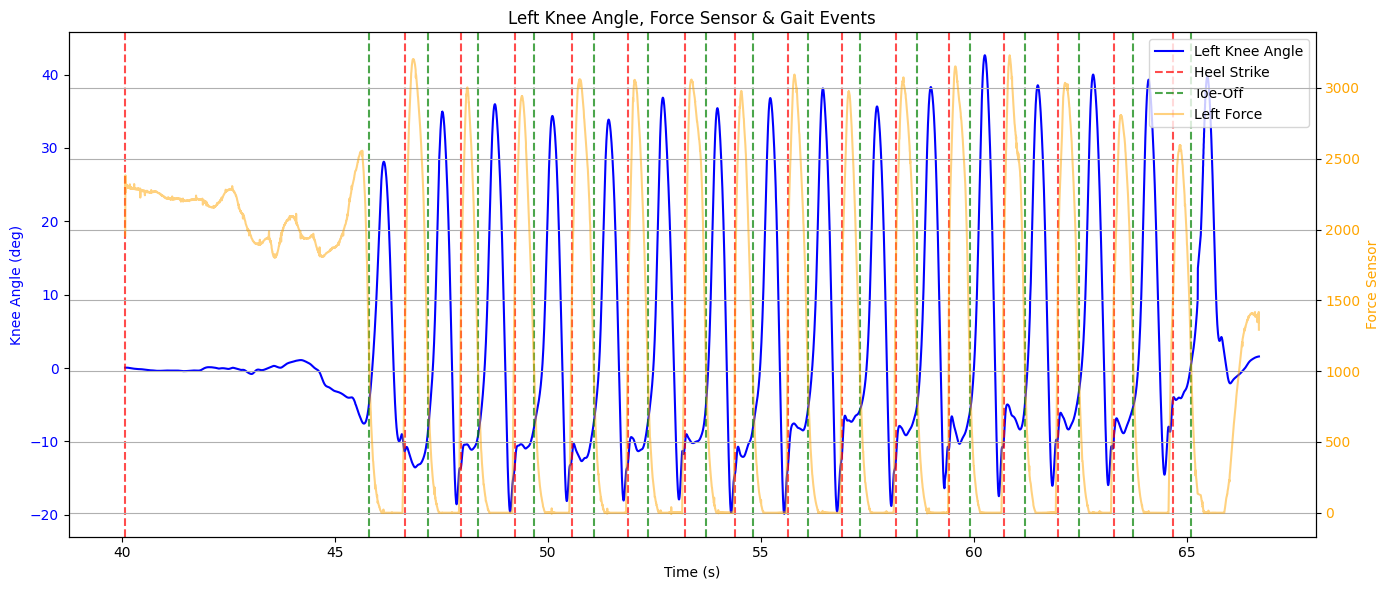

In [15]:
import matplotlib.pyplot as plt

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Left Knee Angle
ax1.plot(time, left_knee_angle, label="Left Knee Angle", color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Knee Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Mark Heel Strikes
for hs in heel_strikes:
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if hs == heel_strikes[0] else "")

# Mark Toe-Offs
for to in toe_offs:
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if to == toe_offs[0] else "")

# Plot Left Force on second axis
ax2 = ax1.twinx()
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.5)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Left Knee Angle, Force Sensor & Gait Events")
plt.grid()
plt.tight_layout()
plt.show()


In [16]:
# Extract gyro for ankle and shank
left_ankle_gyro = data[["LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered"]].to_numpy()
left_shank_gyro = data[["LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered"]].to_numpy()

# Match lengths
min_len = min(len(left_ankle_gyro), len(left_shank_gyro))
left_ankle_gyro = left_ankle_gyro[:min_len]
left_shank_gyro = left_shank_gyro[:min_len]
time = data["Time"].to_numpy()[:min_len] / 1000

# PCA on relative ankle-shank motion
left_ankle_axis = identify_joint_axis(left_ankle_gyro - left_shank_gyro)
ankle_proj = project_onto_joint_axis(left_ankle_gyro, left_ankle_axis)
shank_proj = project_onto_joint_axis(left_shank_gyro, left_ankle_axis)

# Compute ankle angle
left_ankle_angle = integrate_gyro(ankle_proj - shank_proj, time)


In [17]:
labels_ankle, heel_strikes_ankle, toe_offs_ankle = label_gait_phases(left_force, left_ankle_angle, time)

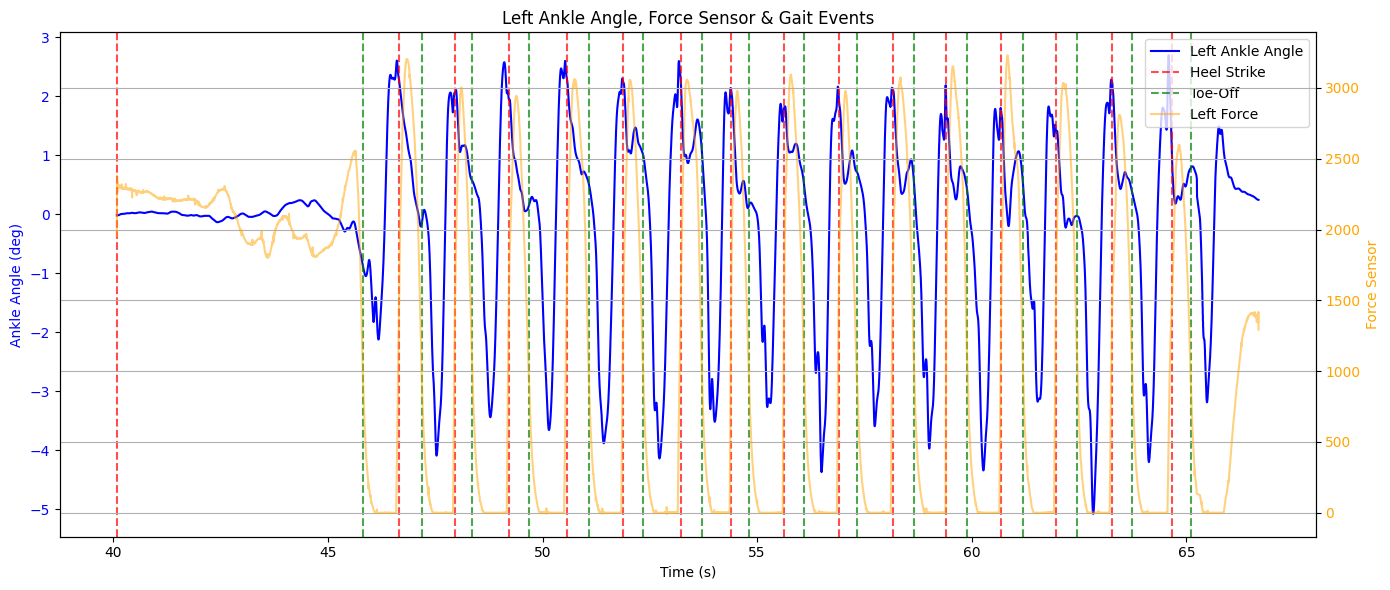

In [18]:
import matplotlib.pyplot as plt

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Left Knee Angle
ax1.plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ankle Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Mark Heel Strikes
for hs in heel_strikes_ankle:
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if hs == heel_strikes_ankle[0] else "")

# Mark Toe-Offs
for to in toe_offs_ankle:
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if to == toe_offs_ankle[0] else "")

# Plot Left Force on second axis
ax2 = ax1.twinx()
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.5)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Left Ankle Angle, Force Sensor & Gait Events")
plt.grid()
plt.tight_layout()
plt.show()


In [19]:
# --- RIGHT LEG ANGLE CALCULATION ---
right_ankle_gyro = data[["RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered"]].to_numpy()
right_shank_gyro = data[["RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered"]].to_numpy()

min_len = min(len(right_ankle_gyro), len(right_shank_gyro))
right_ankle_gyro = right_ankle_gyro[:min_len]
right_shank_gyro = right_shank_gyro[:min_len]
time_r = data["Time"].to_numpy()[:min_len] / 1000
right_force = data["Right_Force"].to_numpy()[:min_len]

# PCA + Projection
right_axis = identify_joint_axis(right_ankle_gyro - right_shank_gyro)
ra_proj = project_onto_joint_axis(right_ankle_gyro, right_axis)
rs_proj = project_onto_joint_axis(right_shank_gyro, right_axis)

# Angle Integration
right_ankle_angle = integrate_gyro(ra_proj - rs_proj, time_r)

# Label Phases
right_labels, right_heel_strikes, right_toe_offs = label_gait_phases(
    right_force, right_ankle_angle, time_r
)

# Save to DataFrame
data["Right_Ankle_Angle"] = np.nan
data["Right_Gait_Phase"] = np.nan
data.loc[:min_len, "Right_Ankle_Angle"] = right_ankle_angle
data.loc[:min_len, "Right_Gait_Phase"] = right_labels


/var/folders/2d/fcgrngd95_b823fdj1fwwj840000gn/T/ipykernel_98388/1061346372.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Start', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air', 'Mid-air

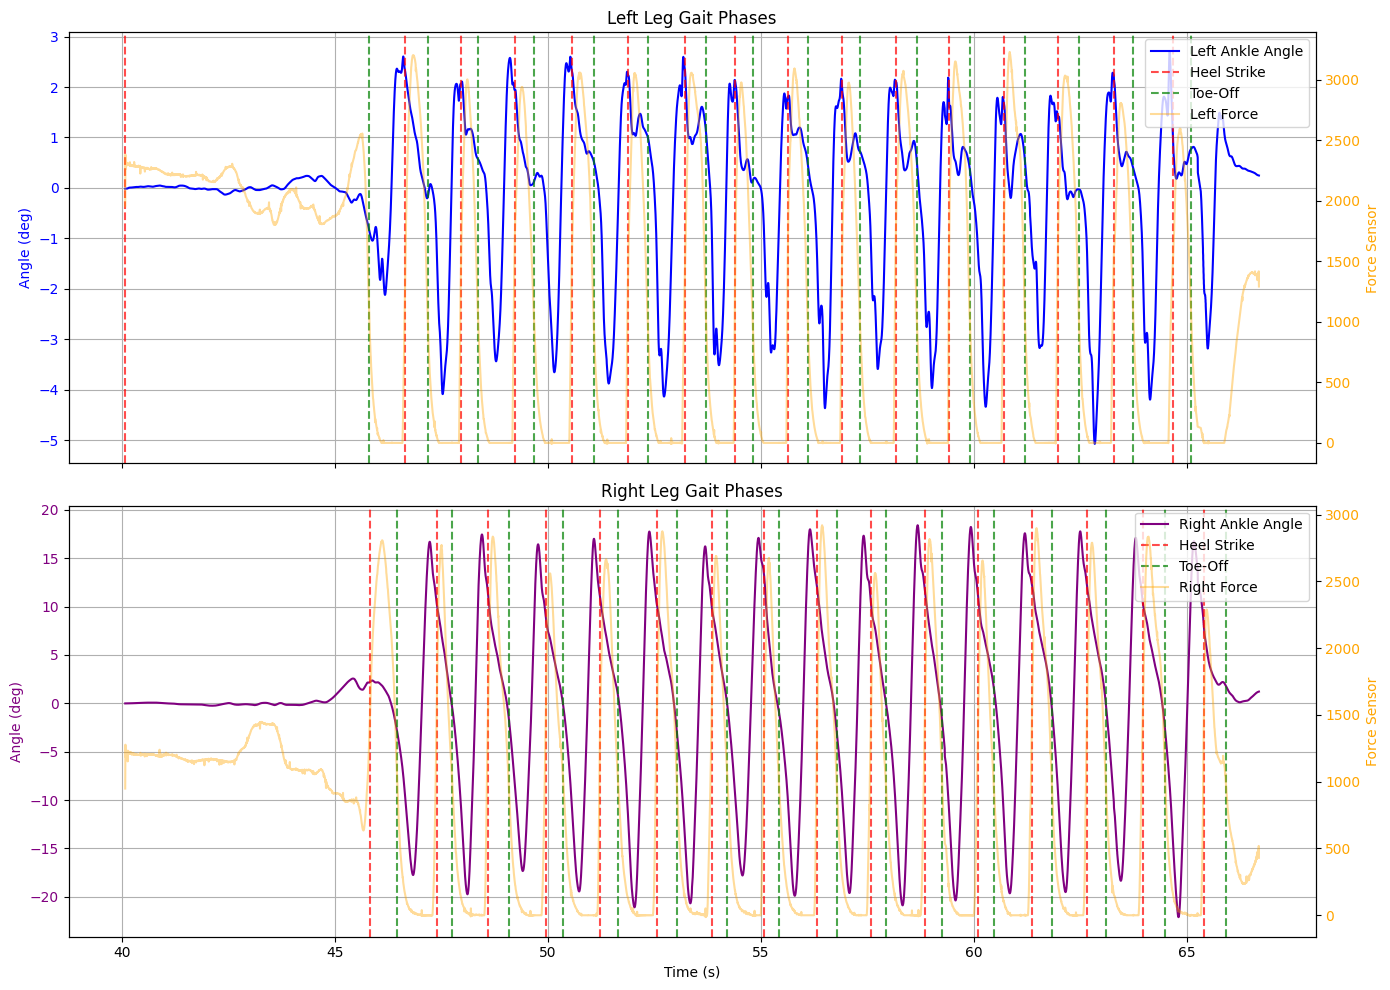

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === LEFT LEG ===
ax1 = axs[0]
ax2 = ax1.twinx()

# Plot angle on left Y-axis
ax1.plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
ax1.set_ylabel("Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Left Leg Gait Phases")

# Plot force on right Y-axis
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.4)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Mark events
for i, hs in enumerate(heel_strikes_ankle):
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax1.grid()

# === RIGHT LEG ===
ax3 = axs[1]
ax4 = ax3.twinx()

# Plot angle on left Y-axis
ax3.plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')
ax3.set_ylabel("Angle (deg)", color='purple')
ax3.tick_params(axis='y', labelcolor='purple')
ax3.set_xlabel("Time (s)")
ax3.set_title("Right Leg Gait Phases")

# Plot force on right Y-axis
ax4.plot(time_r, right_force, label="Right Force", color='orange', alpha=0.4)
ax4.set_ylabel("Force Sensor", color='orange')
ax4.tick_params(axis='y', labelcolor='orange')

# Mark events
for i, hs in enumerate(right_heel_strikes):
    ax3.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    ax3.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Combine legends
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc="upper right")
ax3.grid()

plt.tight_layout()
plt.show()


In [25]:
left_gait_phase = labels
right_gait_phase = right_labels

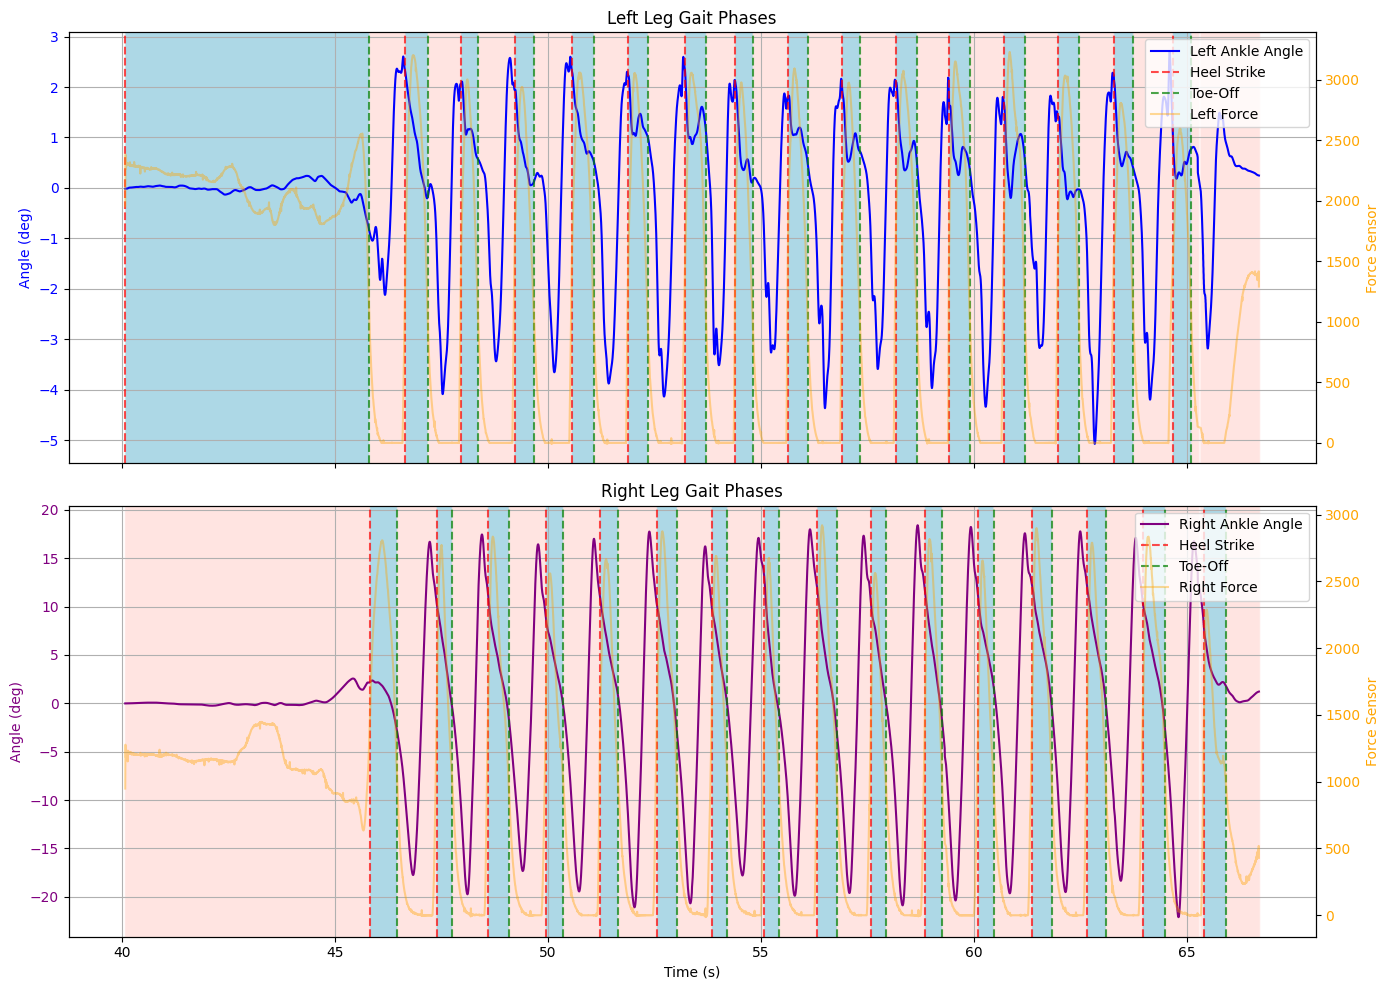

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === LEFT LEG ===
ax1 = axs[0]
ax2 = ax1.twinx()

# Fill stance/swing background
for i in range(1, len(time)):
    if left_gait_phase[i] == "Stance":
        ax1.axvspan(time[i - 1], time[i], color='lightblue', alpha=0.3)
    else:
        ax1.axvspan(time[i - 1], time[i], color='mistyrose', alpha=0.3)


# Plot angle
ax1.plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
ax1.set_ylabel("Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Left Leg Gait Phases")

# Plot force
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.4)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Events
for i, hs in enumerate(heel_strikes_ankle):
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax1.grid()

# === RIGHT LEG ===
ax3 = axs[1]
ax4 = ax3.twinx()

# Fill stance/swing background
for i in range(1, len(time_r)):
    if right_gait_phase[i] == "Stance":
        ax3.axvspan(time_r[i - 1], time_r[i], color='lightblue', alpha=0.3)
    else:
        ax3.axvspan(time_r[i - 1], time_r[i], color='mistyrose', alpha=0.3)


# Plot angle
ax3.plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')
ax3.set_ylabel("Angle (deg)", color='purple')
ax3.tick_params(axis='y', labelcolor='purple')
ax3.set_xlabel("Time (s)")
ax3.set_title("Right Leg Gait Phases")

# Plot force
ax4.plot(time_r, right_force, label="Right Force", color='orange', alpha=0.4)
ax4.set_ylabel("Force Sensor", color='orange')
ax4.tick_params(axis='y', labelcolor='orange')

# Events
for i, hs in enumerate(right_heel_strikes):
    ax3.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    ax3.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Legends
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc="upper right")
ax3.grid()

plt.tight_layout()
plt.show()


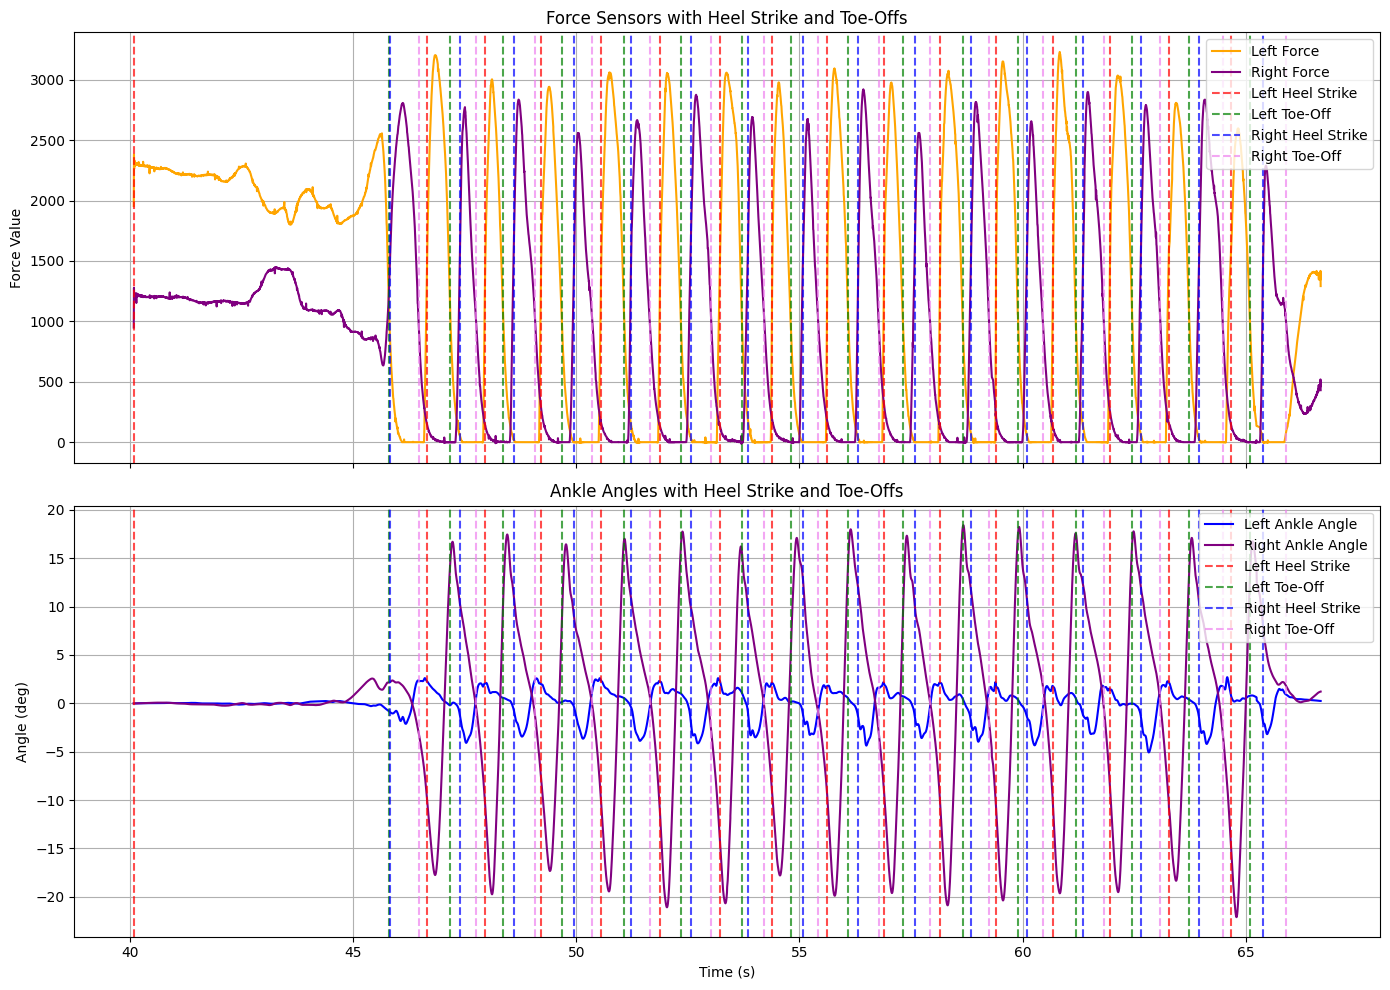

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === PLOT 1: FORCE SENSORS + EVENTS ===
axs[0].plot(time, left_force, label="Left Force", color='orange')
axs[0].plot(time_r, right_force, label="Right Force", color='purple')

# Left Leg Events
for i, hs in enumerate(heel_strikes_ankle):
    axs[0].axvline(hs, color='red', linestyle='--', alpha=0.7, label='Left Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    axs[0].axvline(to, color='green', linestyle='--', alpha=0.7, label='Left Toe-Off' if i == 0 else "")

# Right Leg Events
for i, hs in enumerate(right_heel_strikes):
    axs[0].axvline(hs, color='blue', linestyle='--', alpha=0.7, label='Right Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    axs[0].axvline(to, color='violet', linestyle='--', alpha=0.7, label='Right Toe-Off' if i == 0 else "")

axs[0].set_title("Force Sensors with Heel Strike and Toe-Offs")
axs[0].set_ylabel("Force Value")
axs[0].legend(loc="upper right")
axs[0].grid()

# === PLOT 2: ANKLE ANGLES + EVENTS ===
axs[1].plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
axs[1].plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')

# Left Leg Events
for i, hs in enumerate(heel_strikes_ankle):
    axs[1].axvline(hs, color='red', linestyle='--', alpha=0.7, label='Left Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    axs[1].axvline(to, color='green', linestyle='--', alpha=0.7, label='Left Toe-Off' if i == 0 else "")

# Right Leg Events
for i, hs in enumerate(right_heel_strikes):
    axs[1].axvline(hs, color='blue', linestyle='--', alpha=0.7, label='Right Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    axs[1].axvline(to, color='violet', linestyle='--', alpha=0.7, label='Right Toe-Off' if i == 0 else "")

axs[1].set_title("Ankle Angles with Heel Strike and Toe-Offs")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Angle (deg)")
axs[1].legend(loc="upper right")
axs[1].grid()

plt.tight_layout()
plt.show()


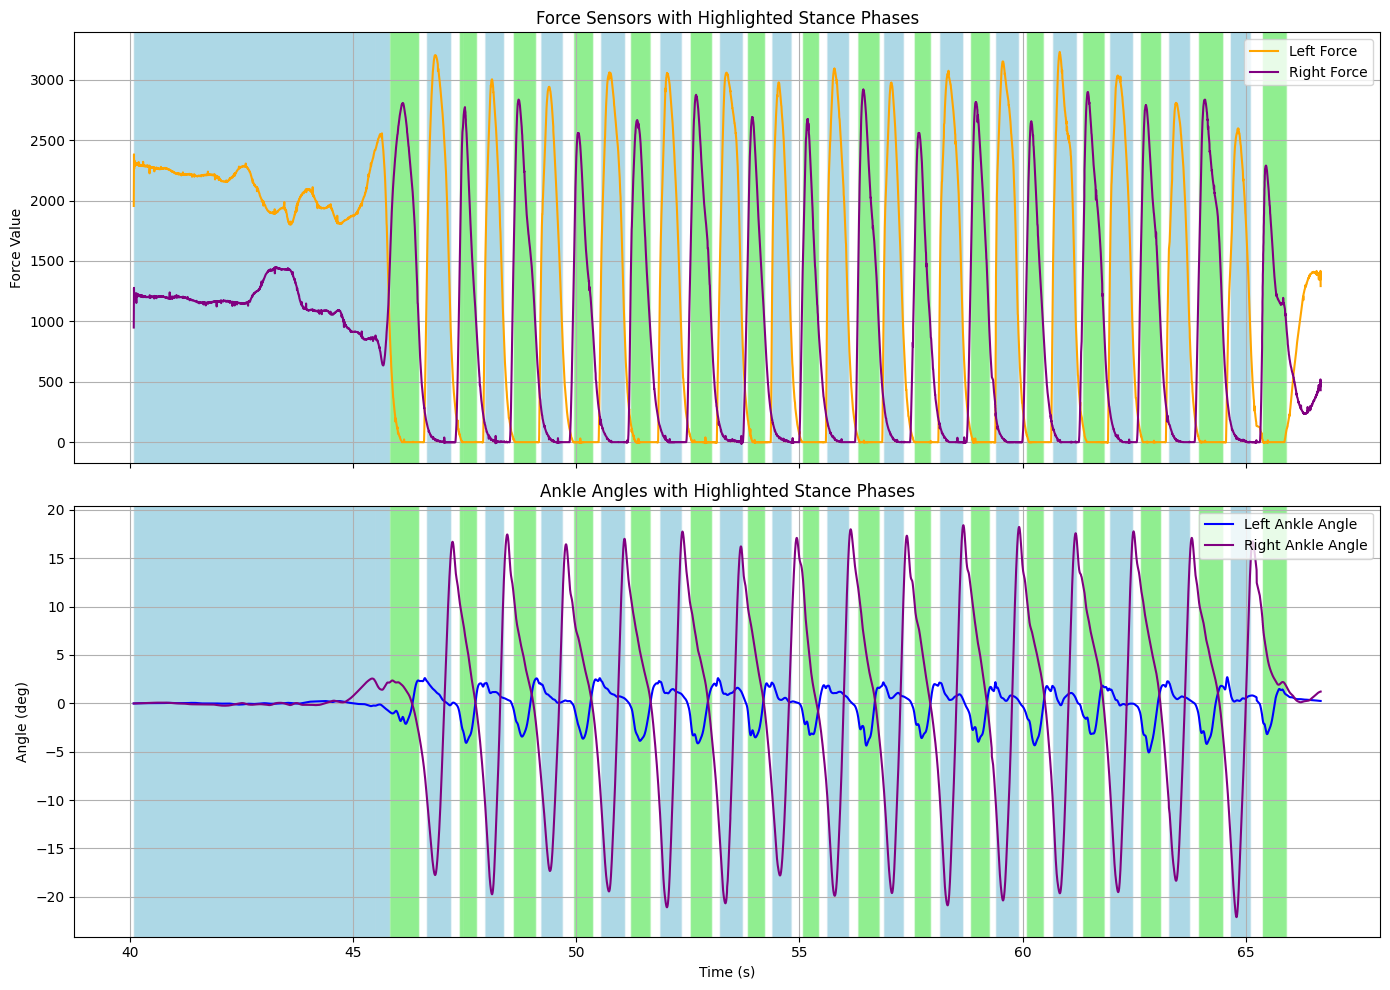

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === PLOT 1: FORCE SENSORS with STANCE PHASES ===
axs[0].plot(time, left_force, label="Left Force", color='orange')
axs[0].plot(time_r, right_force, label="Right Force", color='purple')

# Highlight LEFT Stance (lightblue)
for i in range(1, len(left_gait_phase)):
    if left_gait_phase[i] == "Stance":
        axs[0].axvspan(time[i - 1], time[i], color='lightblue', alpha=0.3)

# Highlight RIGHT Stance (lightgreen)
for i in range(1, len(right_gait_phase)):
    if right_gait_phase[i] == "Stance":
        axs[0].axvspan(time_r[i - 1], time_r[i], color='lightgreen', alpha=0.3)

axs[0].set_title("Force Sensors with Highlighted Stance Phases")
axs[0].set_ylabel("Force Value")
axs[0].legend(loc="upper right")
axs[0].grid()

# === PLOT 2: ANKLE ANGLES with STANCE PHASES ===
axs[1].plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
axs[1].plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')

# Highlight LEFT Stance
for i in range(1, len(left_gait_phase)):
    if left_gait_phase[i] == "Stance":
        axs[1].axvspan(time[i - 1], time[i], color='lightblue', alpha=0.3)

# Highlight RIGHT Stance
for i in range(1, len(right_gait_phase)):
    if right_gait_phase[i] == "Stance":
        axs[1].axvspan(time_r[i - 1], time_r[i], color='lightgreen', alpha=0.3)

axs[1].set_title("Ankle Angles with Highlighted Stance Phases")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Angle (deg)")
axs[1].legend(loc="upper right")
axs[1].grid()

plt.tight_layout()
plt.show()
